# Activity 2.1. Linear Regression
## Introduction
In this activity you learn how to use an optimization algorithm, called Stochastic Gradient Descent (SGD), to build a linear model for regression. In Activity 2, you will be asked to expand the linear regression implementation and develop ridge regression algorithm (linear regression with $\ell_2$ regularization).

## Instructions
<ol>
	<li>Generate a synthetic dataset suitable for regression and divide it to train and test sets,
    <li>Choose and implement a basis function $\pmb{\phi}$, and initialize weight vector $\pmb{w}$, learning rate $\eta$ and termination threshold $\epsilon$.</li>
	<li> Use the above function and repeat the following until the difference between the old and new weight vectors becomes small (i.e., $d(\pmb{w}^{\tau+1}, \pmb{w}^{\tau}) \leq\epsilon$):
<ol>
	<li>Shuffle the training data</li>
	<li>For each datapoint in the training data do:
<ol>
	<li>$\pmb{w}^{(\tau+1)} := \pmb{w}^{(\tau)} + \eta (t - {\pmb{w}^{(\tau)}}.\pmb{\phi}_n) \pmb{\phi}_n$</li>
</ol>
</li>
</ol>
</li>
	<li>Plot the weights $\pmb{w}^{\tau}$ vs. iteration number $\tau$</li>
    <li>Plot the training and testing errors vs. iteration number $\tau$.</li>
    <li>Repeat the above experiments using different datasets, random seeds, initial weights, and $\epsilon$ value</li>
</ol>

## Implementation
### Dataset
Let start with loading libraries and generateing a synthetic dataset, as follows. Here, we generate $N$ data points generated uniformly at random (using `runif`). We then choose a weight vector (called `coeff`) using which we produce the corresponding target value for each data point.  In the training time, we pretend that we don't know the weight vector and we try to learn it using the generated training dataset.

In [ ]:
library(ggplot2) # for plotting functions.
library(reshape2) # for melt and cast functions
set.seed(1234) # to make the results of stochastic methods reproducible

# geberate N x D data samples
N <- 200 # number of all data point (test and train)
D <- 4 # number of features/attributes
data <- data.frame(matrix(runif(D*N), nrow=N, ncol=D))

# generate the labels
coeff <- matrix(c(-5,-3,4,5,10), D+1, 1) # the real coefficient to be estimated
data <- cbind(data,'Y'=as.matrix(cbind(1,data[,1:D])) %*% coeff)
# add gaussian noise the labels (just to make it a little bit more challenging)
data$Y <- data$Y + rnorm(N, mean = 0, sd =1)
pairs(data)

Now, divide the dataset into testing and training sets

In [2]:
# divide data into training and testing sets
train.len <- N/2
train.index <- sample(1:N,train.len)
train.data <- data[train.index,  1:D]
train.label <- data[train.index, 'Y']
test.data <- data[-train.index, 1:D]
test.label <- data[-train.index, 'Y']

## Implementation
Now, based on the instruction, we initialize the parameter values.

### Auxilary Functions
To produce a clean and readable code, let us first define some auxiliary function that calculate the prediction and cost based on the projected data and estimated coefficients.

In [6]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

# auxiliary function to calculate a cost function
error_func <- function (Phi, w, label){
    return(sum((predict_func(Phi, w) - label)^2)/2)
}

### Initialization

In [7]:
# project data using a basis function (identical here)
Phi <- as.matrix(cbind('X0'=1, train.data)) # add a column of 1 as phi_0

T <- train.label # rename just for conviniance
tau.max <- 10000 # maximum number of iterations
eta <- 0.01 # learning rate
epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)

W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)

error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration

tau <- 1 # iteration counter
terminate <- FALSE

### Main Loop

In [9]:
while(!terminate){
    # check termination criteria:
    terminate <- tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon
    
    # shuffle data:
    train.index <- sample(1:train.len, train.len, replace = FALSE)
    Phi <- Phi[train.index,]
    T <- T[train.index]
    
    # for each datapoint:
    for (i in 1:train.len){
        # check termination criteria:
        if (tau >= tau.max | error_func(Phi, W[tau,],T)<=epsilon) {terminate<-TRUE;break}
        
        t_pred = predict_func(Phi[i,], W[tau,])
        # for each coefficient:
        for (j in 1: ncol(W)){
            # update the coefficient:
            W[(tau+1),j] <- W[tau,j] + eta * (T[i]-t_pred) * Phi[i,j]
        }
        
        # record the error:
        error[tau, 'train'] <- error_func(as.matrix(cbind(1, train.data)), W[tau,],train.label)
        error[tau, 'test'] <- error_func(as.matrix(cbind(1, test.data)), W[tau,],test.label)
        
        # update the counter:
        tau <- tau + 1        
    }
}
error.m <- melt(error[1:tau,], id='tau')

# the  final result is:
w <- W[tau,]
cat('The  real coefficents are:',coeff,'\nThe  final coefficents are:',w)

The  real coefficents are: -5 -3 4 5 10 
The  final coefficents are: -4.910687 -3.311366 4.284955 4.818371 9.94484

### Visualizations

  Let's plot the errors of the learned weight vectors over the training iterations on the training and test sets.

Warning message:
: Removed 2 rows containing missing values (geom_path).

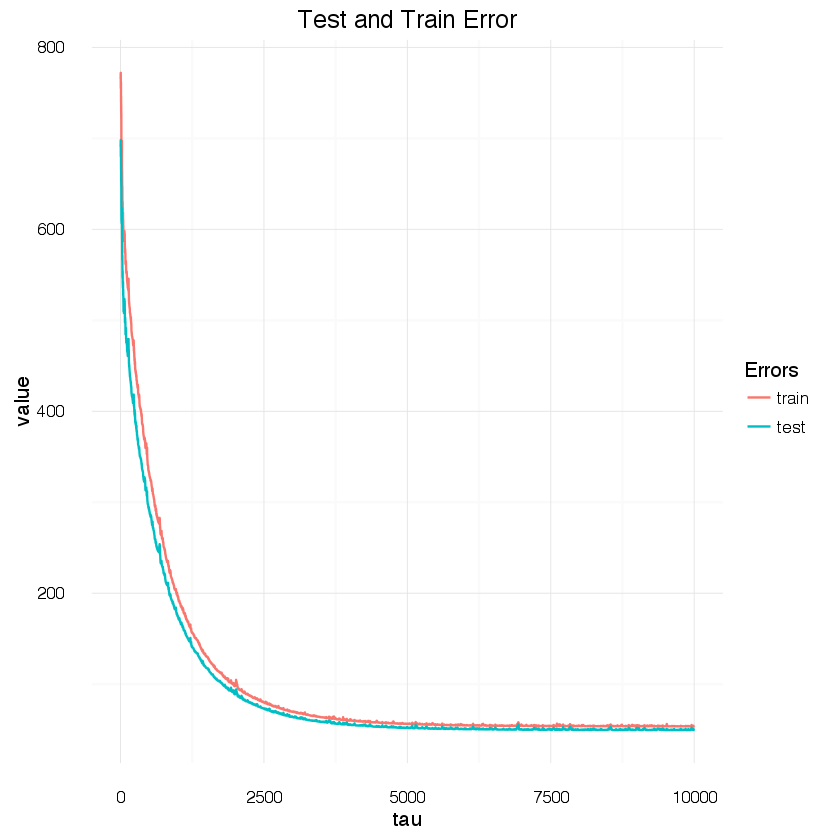

In [10]:
ggplot(data=error.m, aes(x=tau, y=value, color=variable)) +
    geom_line() + ggtitle('Test and Train Error') +
    scale_color_discrete(guide = guide_legend(title = 'Errors')) +theme_minimal()
  

Now let's plot the elements of the learned weight vectors over the training iterations.

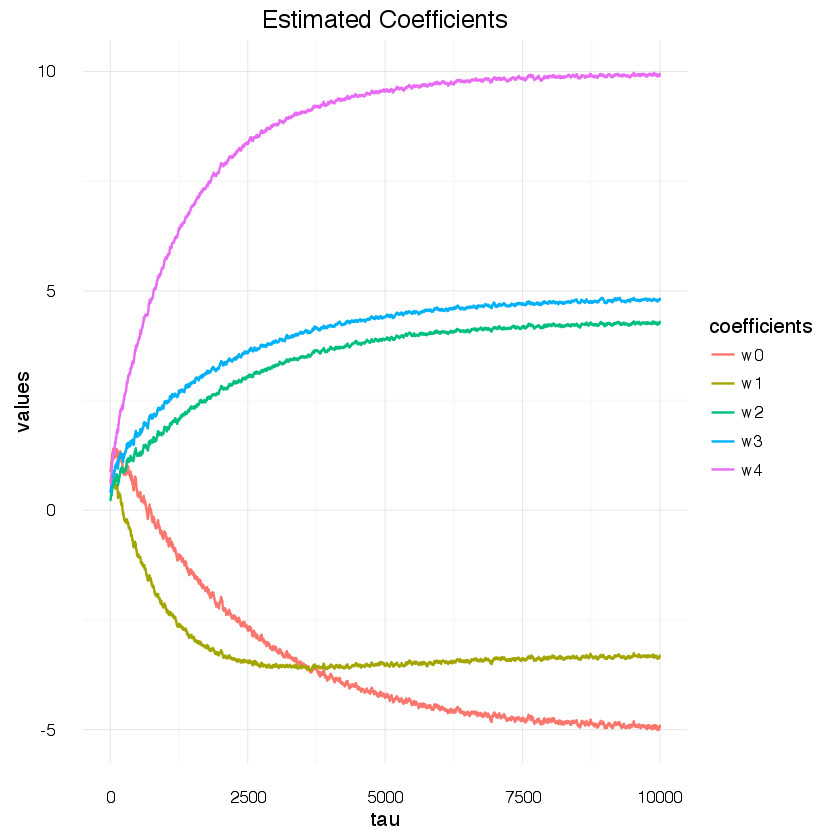

In [11]:
W.m <- as.data.frame(W); names(W.m)<-c('w0','w1','w2','w3','w4')
W.m$tau<-1:nrow(W)
W.m <-melt(W.m, id='tau'); names(W.m) <- c('tau', 'coefficients', 'values')
ggplot(data=W.m, aes(x=tau, y=values, color=coefficients)) + geom_line() + ggtitle('Estimated Coefficients') + theme_minimal()

## Discussions
<ol>

	<li>How the learning rate can affect the convergence rate (i.e., when the algorithm stops improving) and prediction error? Choose some other constant values for the learning rate and investigate their effects.</li>
	<li>Do you believe having different learning rates at different iterations of the main learning loop can help? If it matters, is it better to have large values at start and smaller when close to finish or the other way around? Validate your intuition using monotonically increasing or decreasing learning rates as functions of $\tau$ (e.g. try $\frac{a}{b+\tau}$ for different values of $a$ and $b$).</li>
	<li>Modify your code and develop a batch gradient descent. The main difference is that you do not need to shuffle the training data, but have to include all training samples in the calculation of the weight updates in each iterations. Compare and discuss the convergence rates and final training error for SGD and batch GD. </li>
</ol>